In [45]:
%load_ext autoreload
%autoreload 2

from glycontact.process import *
from glycontact.visualize import *
import os
import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1 - Extracting PDB files from Glycoshape : https://glycoshape.io/

**data are saved in IUPAC folders when downloaded using dedicated functions**

In [2]:
### retrieve all available IUPAC sequences from glycoshape
iupac_list = list(get_glycoshape_IUPAC())
print(len(iupac_list))

print(iupac_list[0:3])

637
['Neu5Ac(a2-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal', 'GlcNAc(b1-3)Fuc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc']


In [11]:
#download_from_glycoshape(iupac_list[0])

In [30]:
### Download full glycoshape except those already downloaded and present in my glycans path
my_glycans_path = "glycans_pdb/"
my_glycans_list = os.listdir(my_glycans_path)


for g in iupac_list:
    if g not in my_glycans_list :
        print(g)
        download_from_glycoshape(g)

Fuc
This IUPAC corresponds to a single monosaccharide: ignored
Xyl
This IUPAC corresponds to a single monosaccharide: ignored
Glc(a1-4)Glc
Glc
This IUPAC corresponds to a single monosaccharide: ignored
Man
This IUPAC corresponds to a single monosaccharide: ignored
GlcNAc
This IUPAC corresponds to a single monosaccharide: ignored
Gal(b1-4)Gal(a1-3)[2-4-diacetimido-2-4-6-trideoxyhexose]
This IUPAC is not formated properly: ignored


# Step 2 - Extracting 3D coordinates from PDB files and replacing PDB to IUPAC nomenclature

In [4]:
### an annotation pipeline is applied on the file to replace PDB with IUPAC nomenclature (explanations in appendix 1)
g = 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc'
df, _ = get_annotation(g, get_example_pdb(g), threshold=3.5)
df

,record_name,atom_number,atom_name,monosaccharide,chain_id,residue_number,x,y,z,occupancy,temperature_factor,element,IUPAC
0,ATOM,1,HO1,ROH,X,1,16.809,18.547,27.403,1.0,0.0,H,-R
1,ATOM,2,O1,ROH,X,1,17.405,18.602,26.649,1.0,0.0,O,-R
2,ATOM,3,C1,NAG,X,2,17.159,19.044,25.312,1.0,0.0,C,GlcNAc(b1-1)
3,ATOM,4,H1,NAG,X,2,16.799,20.071,25.368,1.0,0.0,H,GlcNAc(b1-1)
4,ATOM,5,C2,NAG,X,2,18.454,18.918,24.466,1.0,0.0,C,GlcNAc(b1-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,ATOM,84,OHG,NGC,X,4,28.739,26.745,24.087,1.0,0.0,O,Neu5Gc(a2-3)
84,ATOM,85,HOG,NGC,X,4,27.988,27.323,23.946,1.0,0.0,H,Neu5Gc(a2-3)
85,ATOM,86,O5N,NGC,X,4,26.346,25.380,23.454,1.0,0.0,O,Neu5Gc(a2-3)
86,ATOM,87,O4,NGC,X,4,26.649,21.551,23.093,1.0,0.0,O,Neu5Gc(a2-3)


# Step 3 - Creating a distance table between monosaccharides

### Explanations
For each pair of monosaccharides i and j in the glycan structure, where i and j are integers ranging from 1 to the total number of monosaccharides in the structure (n), the distance (d) between every atom pair is computed as follows:<br><br>
d(i, j) = |xi - xj| + |yi - yj| + |zi - zj|<br><br>
Where:<br>
xi, yi, zi are the coordinates of an atom from the i-th monosaccharide,<br>
xj, yj, zj are the coordinates of an atom from the j-th monosaccharide,<br>
|xi - xj|, |yi - yj|, |zi - zj| are the absolute differences between atomic coordinates of an atom pair between the i-th and j-th monosaccharides. The distance between the closest pair of atoms from two monosaccharides is used as a proxy of the monosaccharide pair distance.<br><br>
This formula calculates the Manhattan distance (also known as L1 norm) between the i-th and j-th monosaccharides in the 3D space.


In [5]:
# table containing observed inter-monosaccharide distances
dist_table = make_monosaccharide_contact_table(df,mode='distance')

# table containing observed inter-monosaccharide distances only if closer to each other than 3A
dist_table_closer = make_monosaccharide_contact_table(df,mode='distance',threshold=3)

# table containing 0 or 1 if inter-monosaccharide distance is above or below the default threshold (10A)
binary_table = make_monosaccharide_contact_table(df,mode='binary')


In [6]:
dist_table

,1_-R,2_GlcNAc(b1-1),3_Gal(b1-3),4_Neu5Gc(a2-3)
1_-R,0,2,8,11
2_GlcNAc(b1-1),2,0,2,7
3_Gal(b1-3),8,2,0,1
4_Neu5Gc(a2-3),11,7,1,0


# Step 4 - Visualizing inter-monosaccharide contact maps

Distance matrices are difficult to interpret and therefore, converted into contact maps

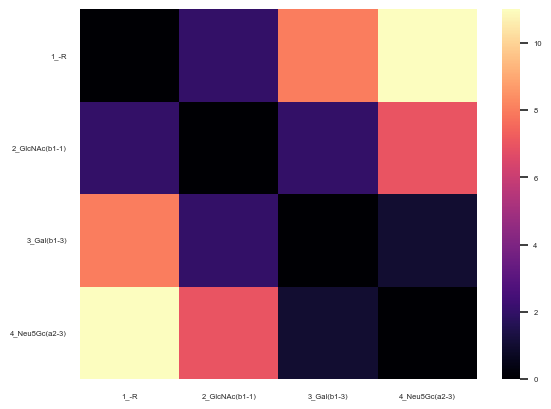

In [7]:
# On contact maps, smaller distances are darker. 

#Here we see two big squares, representing two parts of the glycan. 
# Each part is in tighter interaction with itself than with the other part.
# They correspond respectively to the "trunk" GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc and the "branches" Man(a1-6)[Man(a1-3)]Man(b1-4) of the glycan respectively
draw_contact_map(dist_table)

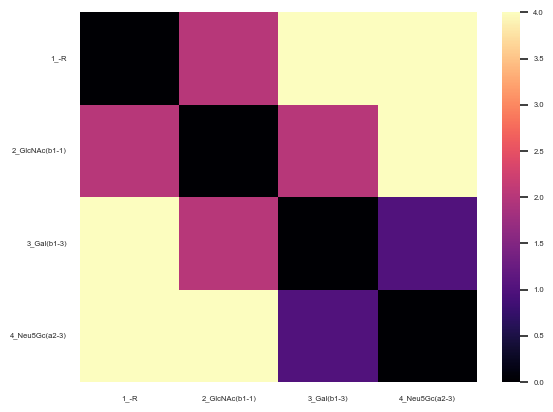

In [8]:
# With a map limited to very close interactions, we can only see binary covalent linkages
draw_contact_map(dist_table_closer)

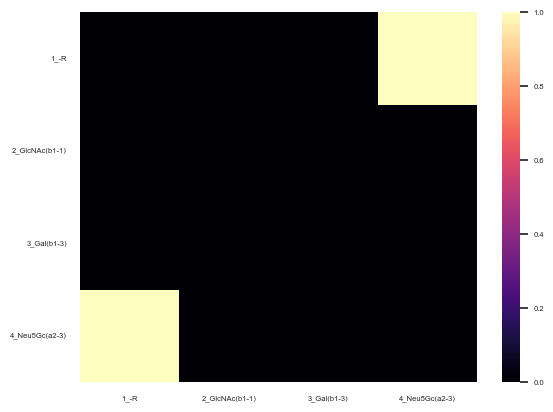

In [9]:
# The binary contact map is just a simplified fingerprint of the interactions, according to a given distance threshold
draw_contact_map(binary_table)

# Step 5 - Creating a distance table between atoms and visualizing intra- and inter-monosaccharide interactions at the atomic level

### Explanations
Same principle as for monosaccharides, but all distances of all atom pairs are kept.

Distance between atoms from the same monosaccharide can be included (inclusive mode) or ignored and set to 0 (exclusive mode)

In [10]:
# table containing observed inter-atomic distances excluding interactions between atoms from the same monosaccharide
dist_table = make_atom_contact_table(df,mode='exclusive')

# table containing observed inter-atomic distances including interactions between atoms from the same monosaccharide
inclusive_dist_table = make_atom_contact_table(df,mode='inclusive')

# setting a very high-threshold allows to visualize all interatomic relations
all_inclusive_dist_table = make_atom_contact_table(df,mode='inclusive', threshold = 200)

In [11]:
dist_table

,1_-R_HO1_1,1_-R_O1_2,2_GlcNAc(b1-1)_C1_3,2_GlcNAc(b1-1)_H1_4,2_GlcNAc(b1-1)_C2_5,2_GlcNAc(b1-1)_H2_6,2_GlcNAc(b1-1)_N2_7,2_GlcNAc(b1-1)_H2N_8,2_GlcNAc(b1-1)_C2N_9,2_GlcNAc(b1-1)_CME_10,...,4_Neu5Gc(a2-3)_H5N_79,4_Neu5Gc(a2-3)_C5N_80,4_Neu5Gc(a2-3)_CME_81,4_Neu5Gc(a2-3)_H2M_82,4_Neu5Gc(a2-3)_H1M_83,4_Neu5Gc(a2-3)_OHG_84,4_Neu5Gc(a2-3)_HOG_85,4_Neu5Gc(a2-3)_O5N_86,4_Neu5Gc(a2-3)_O4_87,4_Neu5Gc(a2-3)_H4O_88
1_-R_HO1_1,0.000,0.000,2.938,3.569,4.953,5.520,6.224,7.737,5.304,6.604,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
1_-R_O1_2,0.000,0.000,2.025,3.356,3.548,4.225,4.819,6.332,3.899,5.423,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
2_GlcNAc(b1-1)_C1_3,2.938,2.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
2_GlcNAc(b1-1)_H1_4,3.569,3.356,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
2_GlcNAc(b1-1)_C2_5,4.953,3.548,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_Neu5Gc(a2-3)_OHG_84,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_Neu5Gc(a2-3)_HOG_85,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_Neu5Gc(a2-3)_O5N_86,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_Neu5Gc(a2-3)_O4_87,11.000,11.000,11.000,11.000,11.000,11.000,11.000,9.417,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
all_inclusive_dist_table

,1_-R_HO1_1,1_-R_O1_2,2_GlcNAc(b1-1)_C1_3,2_GlcNAc(b1-1)_H1_4,2_GlcNAc(b1-1)_C2_5,2_GlcNAc(b1-1)_H2_6,2_GlcNAc(b1-1)_N2_7,2_GlcNAc(b1-1)_H2N_8,2_GlcNAc(b1-1)_C2N_9,2_GlcNAc(b1-1)_CME_10,...,4_Neu5Gc(a2-3)_H5N_79,4_Neu5Gc(a2-3)_C5N_80,4_Neu5Gc(a2-3)_CME_81,4_Neu5Gc(a2-3)_H2M_82,4_Neu5Gc(a2-3)_H1M_83,4_Neu5Gc(a2-3)_OHG_84,4_Neu5Gc(a2-3)_HOG_85,4_Neu5Gc(a2-3)_O5N_86,4_Neu5Gc(a2-3)_O4_87,4_Neu5Gc(a2-3)_H4O_88
1_-R_HO1_1,0.000,1.405,2.938,3.569,4.953,5.520,6.224,7.737,5.304,6.604,...,22.975,21.745,23.581,25.309,23.293,23.444,23.412,20.319,17.154,16.544
1_-R_O1_2,1.405,0.000,2.025,3.356,3.548,4.225,4.819,6.332,3.899,5.423,...,21.570,20.340,22.176,23.904,21.888,22.039,22.007,18.914,15.749,15.139
2_GlcNAc(b1-1)_C1_3,2.938,2.025,0.000,1.443,2.267,3.576,3.286,4.799,4.064,6.564,...,20.037,18.807,20.643,22.371,20.355,20.506,20.474,17.381,14.216,13.606
2_GlcNAc(b1-1)_H1_4,3.569,3.356,1.443,0.000,3.710,5.019,3.587,4.188,5.033,5.841,...,19.426,18.196,20.032,21.760,19.744,19.895,19.863,16.770,13.605,12.995
2_GlcNAc(b1-1)_C2_5,4.953,3.548,2.267,3.710,0.000,1.415,2.435,3.212,3.741,6.241,...,18.022,16.792,18.628,20.356,18.340,18.491,18.459,15.366,12.201,11.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_Neu5Gc(a2-3)_OHG_84,23.444,22.039,20.506,19.895,18.491,19.234,17.220,15.707,18.140,16.840,...,6.187,4.307,2.107,2.729,3.343,0.000,1.470,4.391,8.278,8.630
4_Neu5Gc(a2-3)_HOG_85,23.412,22.007,20.474,19.863,18.459,19.202,17.188,15.675,18.108,16.808,...,6.157,3.993,3.295,3.917,4.531,1.470,0.000,4.077,7.964,8.316
4_Neu5Gc(a2-3)_O5N_86,20.319,18.914,17.381,16.770,15.366,16.109,14.095,12.582,15.015,13.715,...,5.364,1.912,3.262,4.990,3.738,4.391,4.077,0.000,4.493,5.623
4_Neu5Gc(a2-3)_O4_87,17.154,15.749,14.216,13.605,12.201,12.944,10.930,9.417,11.850,10.550,...,5.821,4.591,6.427,8.155,6.475,8.278,7.964,4.493,0.000,1.388


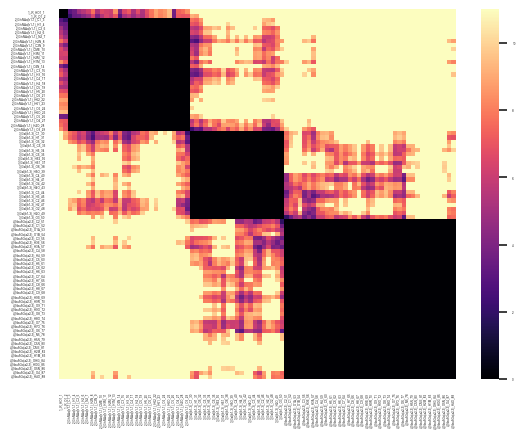

In [13]:
draw_contact_map(dist_table,size = 0.2)

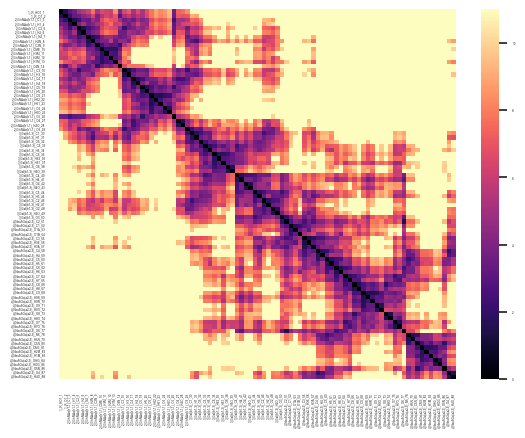

In [14]:
draw_contact_map(inclusive_dist_table,size = 0.2)

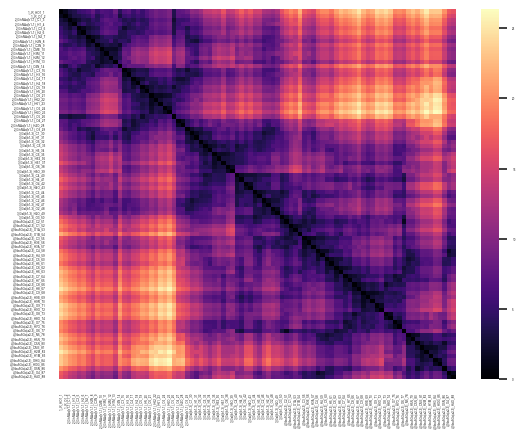

In [15]:
draw_contact_map(all_inclusive_dist_table,size = 0.2)

# Step 6 - Visualizing multiple structures of the same glycan

For a given glycan, multiple structures (or clusters) are determined.
It is therefore possible to generate multiple maps and create a gif to visualize them

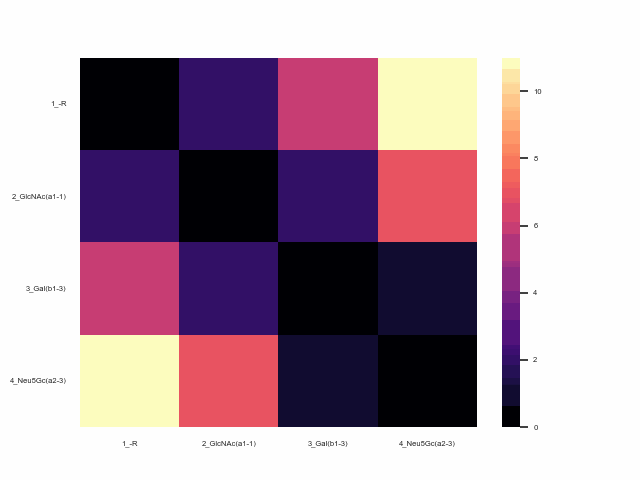

In [16]:
### Monosaccharide contact maps from alpha linked molecules
# Select alpha-linked glycan pdb files
mono_tables = get_contact_tables(g, 'alpha')

#Create a gif
make_gif('monosaccharide_alpha', mono_tables)

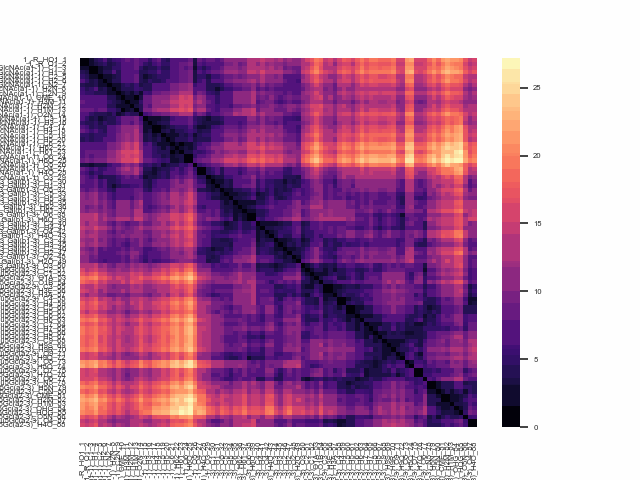

In [17]:
#Now for atoms
atom_tables = get_contact_tables(g, 'alpha', level='atom')
#Create a gif
make_gif('atom_alpha', atom_tables)



# Step 7 - Determination of stable monosaccharide/atom pairs across structural clusters

### Explanations
Two methods can be specified to determine monosaccharide/atom stability across structural clusters.

Method 1:<br>
For each pair of entities pE (monosaccharide or atom) in each structure S, the average distance D is computed as follows:<br><br>
D(pE) = (D(pE_S1) + D(pE_S2) + ... + D(pE_Sn)) / n<br><br>
Where:<br>
pE is a pair of entities (monosaccharide or atom),<br>
D(pE_Si) is the distance between the pair of entities in the i-th structure, n is the total number of structures.<br><br>
Then, the instability score I for the pair of entities pE is computed as follows:<br><br>
I(pE) = SUM(|D(pE_S1) - D(pE)|, |D(pE_S2) - D(pE)|, ..., |D(pE_Sn) - D(pE)|)<br><br>
Where:<br>
I(pE) is the instability score for the pair of entities pE,<br>
SUM is the sum of all absolute differences between the distance of the pair of entities in each structure and the average distance.<br><br><br>
Method 2 (amplify):<br>
The second method is similar to the first one, but in the last step, the power of 2of the instability score is used instead.

In [18]:

# from the contact maps, compute standard and amplified inter-structure variability tables
isvt_amplified = inter_structure_variability_table(mono_tables, 'amplify')
isvt = inter_structure_variability_table(mono_tables)

atom_isvt_amplified = inter_structure_variability_table(atom_tables, 'amplify')
atom_isvt = inter_structure_variability_table(atom_tables)

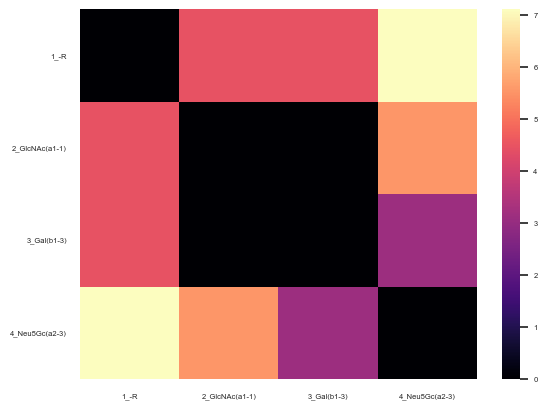

In [19]:
# Instability across structure is represented by bright colors. 
# The darker, the most stable monosaccharide pairs are across structures.
draw_contact_map(isvt)

<Axes: >

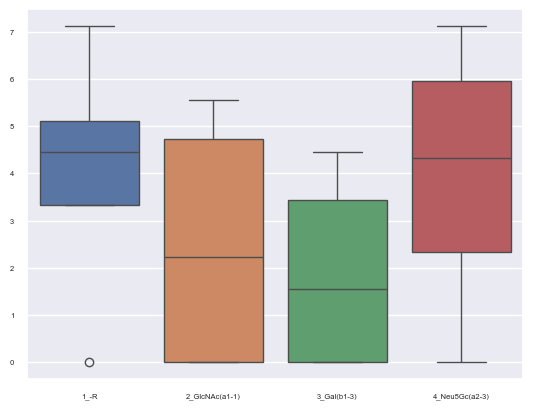

In [20]:
# monosaccharide instability can also be visualized through seaborn boxplots
sns.boxplot(isvt)

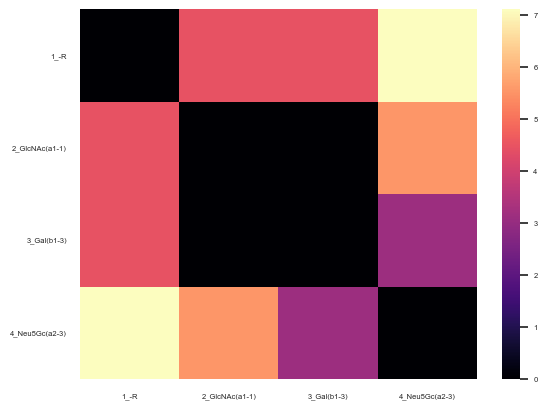

In [21]:
# Differences in terms of stability are exacerbated with the amplified mode
draw_contact_map(isvt_amplified)

<Axes: >

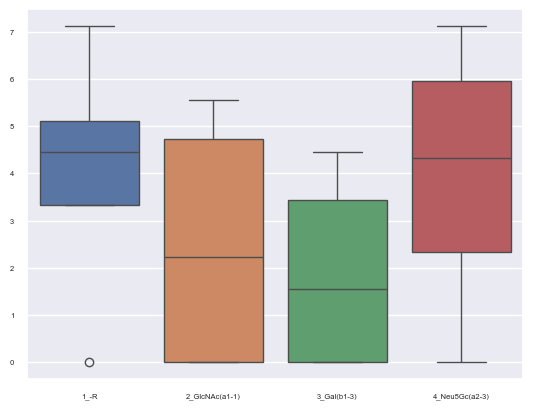

In [22]:
# Differences in terms of stability are exacerbated with the amplified mode also in the boxplots
sns.boxplot(isvt_amplified)

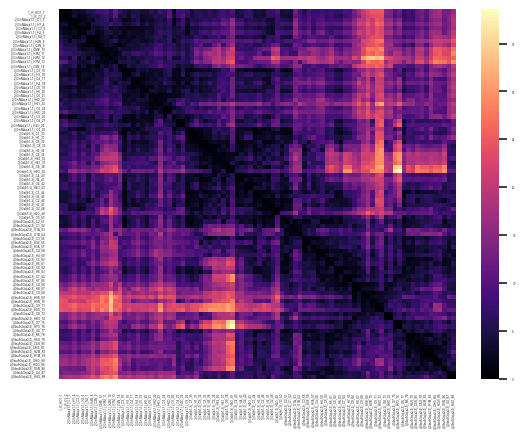

In [23]:
# Atom contact maps are higher-resolution versions of monosaccharide contact maps
draw_contact_map(atom_isvt,size =0.2)

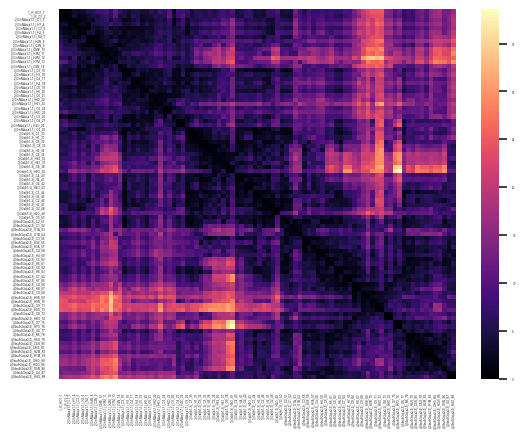

In [24]:
draw_contact_map(atom_isvt_amplified,size =0.2)

In [26]:
residue_overall_stability = {}
for c in isvt.columns.to_list():
    residue_overall_stability[c] = sum(isvt[c].to_list())

sorted_residue_overall_stability = sorted(residue_overall_stability.items(), key=lambda x:x[1])
print(sorted_residue_overall_stability)

[('3_Gal(b1-3)', 7.555555555555556), ('2_GlcNAc(a1-1)', 9.999999999999998), ('4_Neu5Gc(a2-3)', 15.777777777777775), ('1_-R', 16.0)]


In [27]:
residue_overall_stability = {}
for c in atom_isvt.columns.to_list():
    residue_overall_stability[c] = sum(atom_isvt[c].to_list())

sorted_residue_overall_stability = sorted(residue_overall_stability.items(), key=lambda x:x[1])
print(sorted_residue_overall_stability)

[('4_Neu5Gc(a2-3)_C2_51', 467.8159999999999), ('3_Gal(b1-3)_C3_44', 494.14155555555567), ('3_Gal(b1-3)_O3_50', 500.4873333333333), ('3_Gal(b1-3)_H2_47', 532.4122222222221), ('3_Gal(b1-3)_C2_46', 541.2557777777778), ('4_Neu5Gc(a2-3)_C1_52', 543.5942222222222), ('2_GlcNAc(a1-1)_O3_29', 547.6262222222223), ('2_GlcNAc(a1-1)_C3_15', 554.4588888888889), ('4_Neu5Gc(a2-3)_H6_63', 564.1337777777777), ('3_Gal(b1-3)_C1_30', 565.3622222222223), ('4_Neu5Gc(a2-3)_C3_55', 566.5384444444442), ('4_Neu5Gc(a2-3)_O6_77', 583.6548888888889), ('4_Neu5Gc(a2-3)_C6_62', 585.7644444444444), ('3_Gal(b1-3)_H3_45', 602.1766666666667), ('3_Gal(b1-3)_O5_32', 615.4715555555556), ('3_Gal(b1-3)_O4_42', 617.2920000000001), ('2_GlcNAc(a1-1)_H5_20', 618.3208888888888), ('2_GlcNAc(a1-1)_O4_27', 622.0831111111114), ('2_GlcNAc(a1-1)_C4_17', 631.7644444444446), ('3_Gal(b1-3)_C4_40', 635.3591111111111), ('4_Neu5Gc(a2-3)_H3A_57', 640.7646666666666), ('3_Gal(b1-3)_H4O_43', 641.304222222222), ('4_Neu5Gc(a2-3)_C5_60', 645.11355555

# Step 8 - From PDB to Pearson correlations

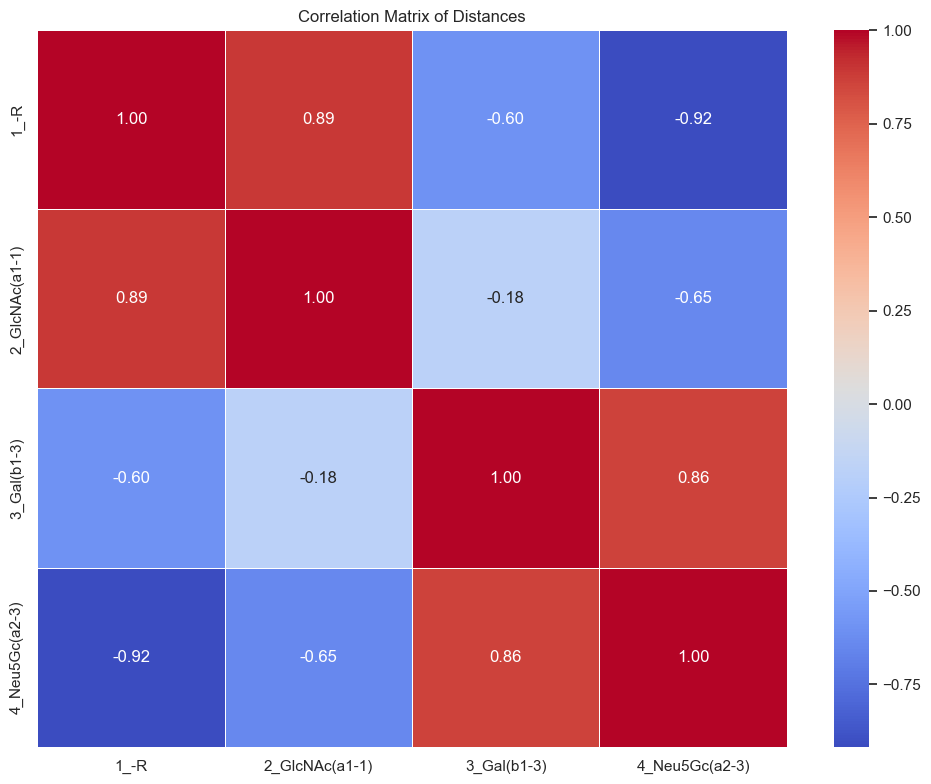

In [28]:
mx = make_correlation_matrix(mono_tables)
show_correlations(mx)

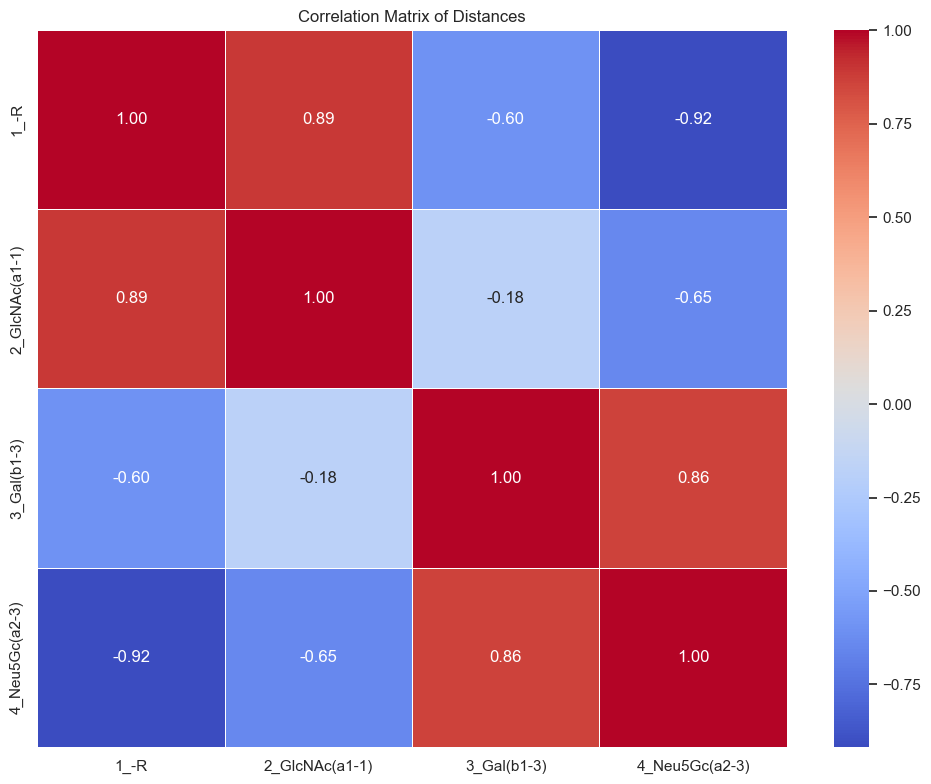

In [29]:
# Computing the correlation matrix and displaying it as a heatmap

mx = make_correlation_matrix(mono_tables)
show_correlations(mx)

# On the map, high values (red) between the relative distances of a pair of residues compared to all other residues. 
# 0 (white) means no correlation
# Low negative values (blue) mean anti-correlations


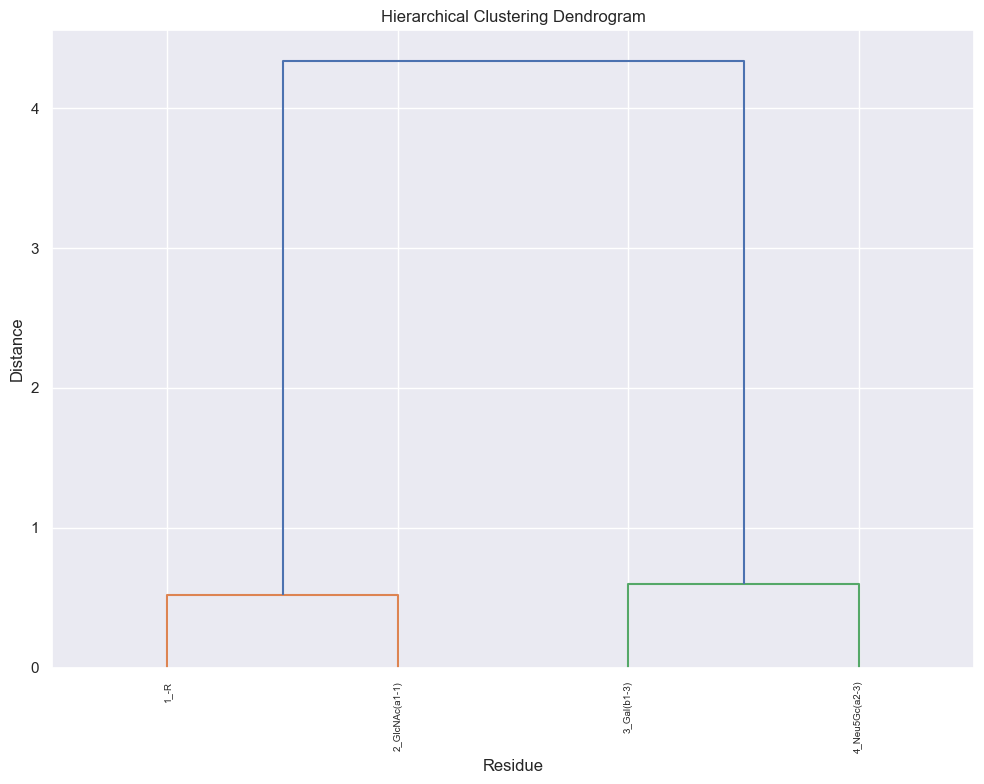

{'C1': ['1_-R', '2_GlcNAc(a1-1)'], 'C2': ['3_Gal(b1-3)', '4_Neu5Gc(a2-3)']}

In [30]:
# clustering of correlated residues
show_correlation_dendrogram(mx, font_size = 7)

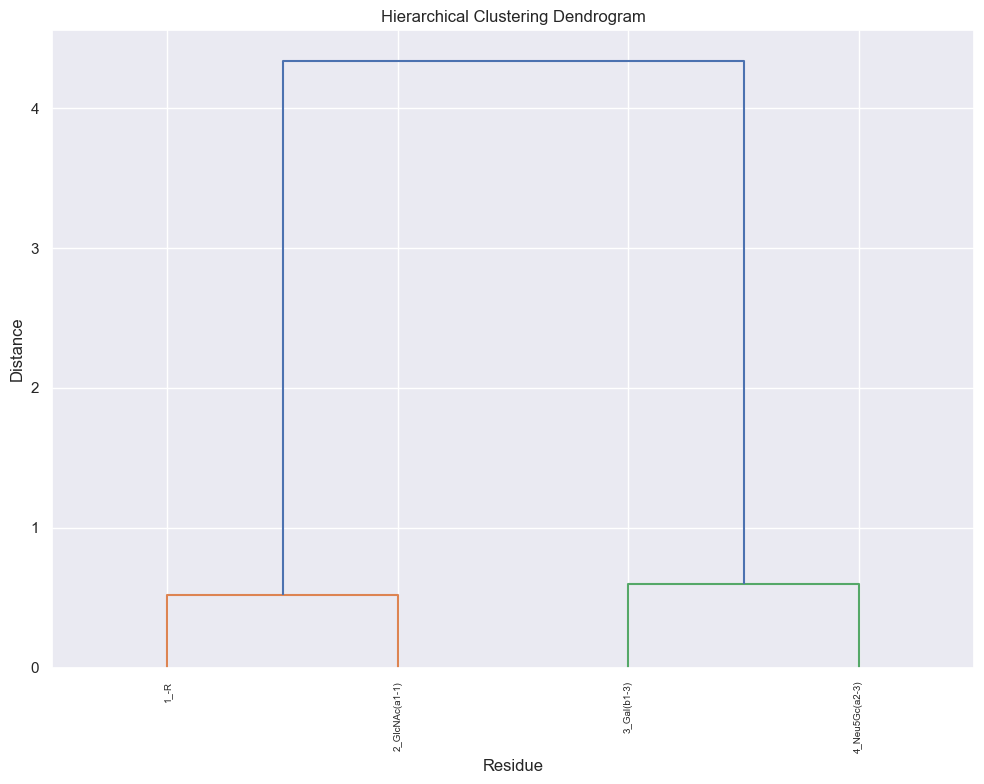

{'C2': ['3_Gal(b1-3)', '4_Neu5Gc(a2-3)'], 'C1': ['1_-R', '2_GlcNAc(a1-1)']}

In [97]:
# clustering of correlated residues
show_correlation_dendrogram(mx, font_size = 7)

icoord[[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0]]
dcoord[[0.0, 0.5216630984495478, 0.5216630984495478, 0.0], [0.0, 0.5953329815273255, 0.5953329815273255, 0.0], [0.5216630984495478, 4.339097767279943, 4.339097767279943, 0.5953329815273255]]
ivl['1_-R', '2_GlcNAc(a1-1)', '3_Gal(b1-3)', '4_Neu5Gc(a2-3)']
leaves[0, 1, 2, 3]
color_list['C1', 'C2', 'C0']
leaves_color_list['C1', 'C1', 'C2', 'C2']


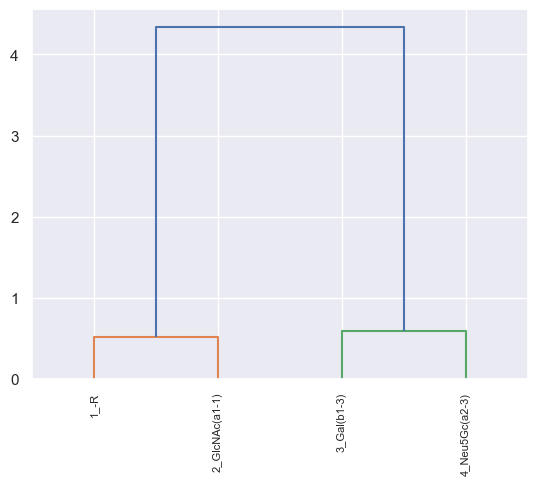

In [98]:
show_correlation_dendrogram(mx)

# Step 9 - Contact frequency table and heatmap

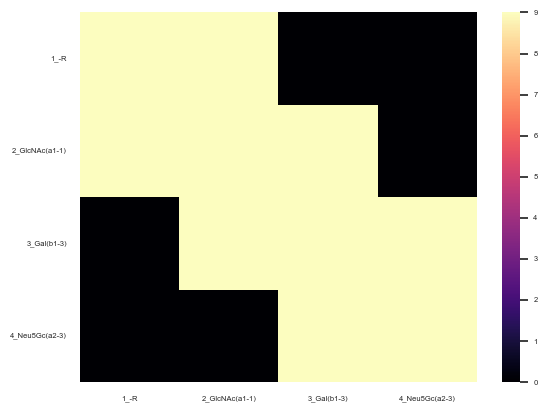

In [31]:
# Given a specific threshold, count the frequency of contact (= two residues being closer than threshold) across multiple dataframes
isft = inter_structure_frequency_table(mono_tables, threshold = 3)
draw_contact_map(isft)

# Step 10 - Monosaccharide preferences

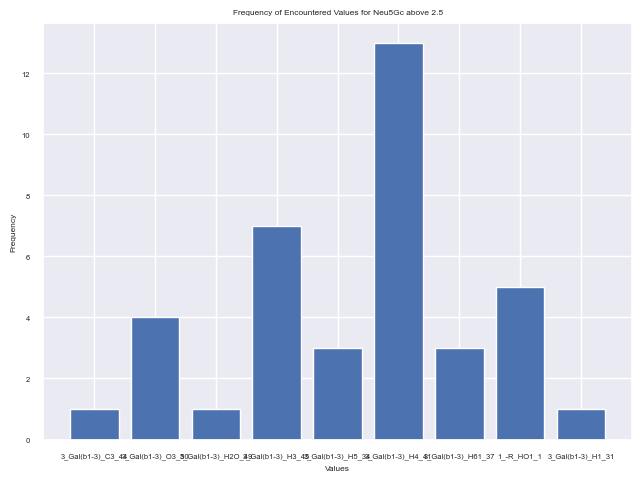

In [32]:
show_monosaccharide_preference_structure(dist_table,'Neu5Gc',2.5,mode='default')

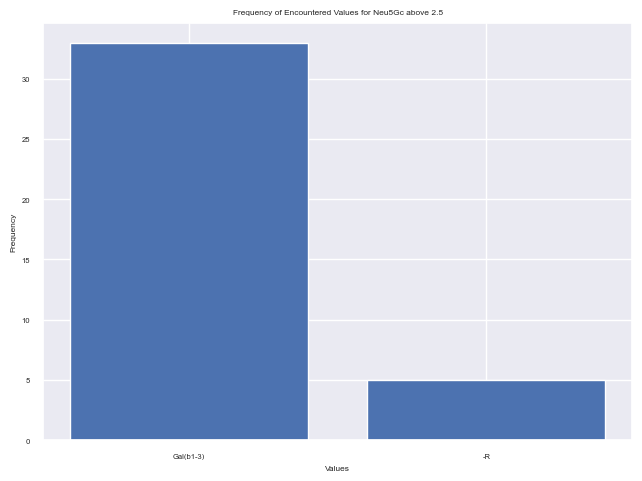

In [33]:
show_monosaccharide_preference_structure(dist_table,'Neu5Gc',2.5,mode='monolink')

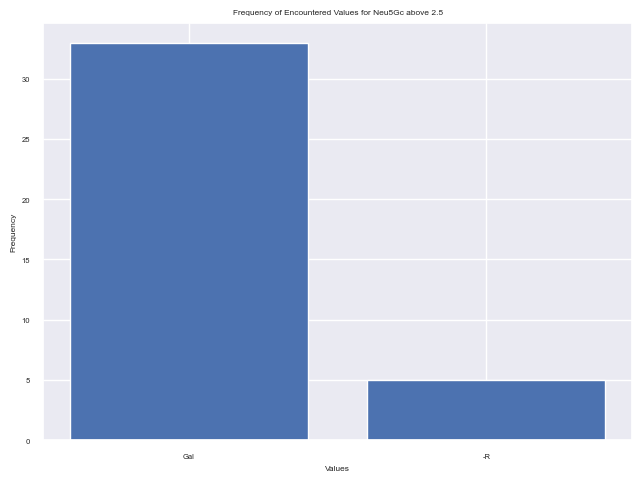

In [34]:
show_monosaccharide_preference_structure(dist_table,'Neu5Gc',2.5,mode='monosaccharide')

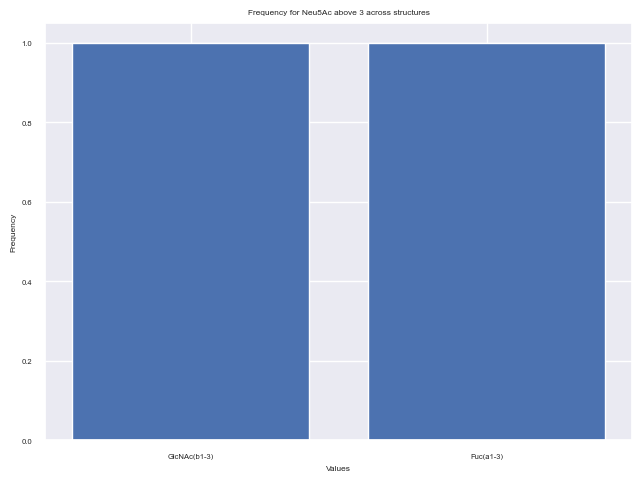

In [36]:
multi_glycan_monosaccharide_preference_structure(iupac_list[0], monosaccharide="Neu5Ac",threshold=3, mode= "monolink")